In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
#from tensorflow.python.keras import backend as K
import glob
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, BatchNormalization, Dropout, Reshape
from keras.optimizers import Adam
from keras.models import Model
from matplotlib import pyplot

In [3]:
all_files = glob.glob("data/*.csv")
#all_files = glob.glob("data/autopilot_2019_03_18__13_20_22.csv")

li = []
for filename in all_files:
    print("Loading", filename)
    df = pd.read_csv(filename, header=None)
    df.drop(df.tail(1).index,inplace=True)
    li.append(df)

dataset = pd.concat(li, axis=0).sample(frac=1)

#DEV TO REDUCE DATASET
#dataset = dataset.iloc[:1000,:]

Y_data = dataset.iloc[:,-2:]
X_data = dataset.iloc[:,:-2]

Loading data/autopilot_2019_03_23__18_02_57.csv
Loading data/autopilot_2019_03_18__13_17_35.csv
Loading data/autopilot_2019_03_18__13_20_22.csv
Loading data/autopilot_2019_03_23__18_01_43.csv
Loading data/autopilot_2019_03_17__02_57_50.csv
Loading data/autopilot_2019_03_23__17_59_34.csv
Loading data/autopilot_2019_03_17__03_55_47.csv
Loading data/autopilot_2019_03_18__12_42_35.csv
Loading data/autopilot_2019_03_17__03_57_58.csv
Loading data/autopilot_2019_03_18__13_19_00.csv
Loading data/autopilot_2019_03_17__03_51_44.csv
Loading data/autopilot_2019_03_18__13_16_35.csv
Loading data/autopilot_2019_03_18__12_44_29.csv
Loading data/autopilot_2019_03_23__18_00_53.csv
Loading data/autopilot_2019_03_18__13_09_23.csv
Loading data/autopilot_2019_03_17__03_54_00.csv
Loading data/autopilot_2019_03_18__12_43_28.csv
Loading data/autopilot_2019_03_17__03_53_15.csv
Loading data/autopilot_2019_03_18__12_41_36.csv
Loading data/autopilot_2019_03_17__02_59_54.csv
Loading data/autopilot_2019_03_18__13_08

In [4]:
split_offset = int(X_data.shape[0] * .05)
Y_test  = Y_data.iloc[:split_offset,:]
Y_train = Y_data.iloc[split_offset:,:]
X_test  = X_data.iloc[:split_offset,:]
X_train = X_data.iloc[split_offset:,:]
assert X_train.shape[1] == X_test.shape[1]
assert Y_train.shape[1] == Y_test.shape[1]
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]
print(X_train.shape[1], "feature values")
print(Y_train.shape[1], "output values")
print(X_train.shape[0], "training lines")
print(Y_test.shape[0], "testing lines")

2271 feature values
2 output values
48093 training lines
2531 testing lines


In [329]:
first_selfcar_inputs = 3
features_by_car = 6
cells_by_row = 18
car_features = cells_by_row * cells_by_row * features_by_car
blocks_offset = first_selfcar_inputs + car_features

raw_input = Input(shape=(X_train.shape[1],), name='raw_input')

selfcar = Lambda(
    lambda x: K.slice(x, [0,0], [-1,first_selfcar_inputs]),
    output_shape=(first_selfcar_inputs,),
    name='selfcar_input'
)(raw_input)

blocks = Lambda(
    lambda x: K.slice(x, [0,blocks_offset], [-1,-1]),
    output_shape=(cells_by_row * cells_by_row,),
    name='blocks_input_slice'
)(raw_input)

blocks = Reshape(
    (cells_by_row, cells_by_row, 1,),
    input_shape=(cells_by_row, cells_by_row, 1,),
    name='blocks_input_reshape'
)(blocks)

cars = Lambda(
    lambda x: K.slice(x, [0,first_selfcar_inputs], [-1,car_features]),
    output_shape=(car_features,),
    name='cars_input_slice'
)(raw_input)

cars = Reshape(
    (cells_by_row, cells_by_row, features_by_car,),
    input_shape=(cells_by_row * cells_by_row * features_by_car,),
    name='cars_input_reshape'
)(cars)

selfcar = BatchNormalization()(selfcar)
selfcar = Dense(4, activation='relu', name='dense_selfcar_1')(selfcar)
selfcar = BatchNormalization()(selfcar)
selfcar = Dense(8, activation='relu', name='dense_selfcar_2')(selfcar)
selfcar = BatchNormalization()(selfcar)
selfcar = Dense(8, activation='relu', name='dense_selfcar_3')(selfcar)

blocks = Conv2D(8, (4, 4), padding='same', name='conv_blocks_0')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Conv2D(16, (2, 2), name='conv_blocks_1')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_1')(blocks)
blocks = Conv2D(32, (2, 2), name='conv_blocks_2')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_2')(blocks)
blocks = Conv2D(64, (1, 1), name='conv_blocks_3')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_3')(blocks)
blocks = Conv2D(128, (1, 1), name='conv_blocks_4')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Flatten(name='flatten_blocks')(blocks)
blocks = Dense(32, activation='relu', name='dense_blocks_1')(Concatenate()([blocks, selfcar]))
blocks = BatchNormalization()(blocks)
blocks = Dense(16, activation='relu', name='dense_blocks_2')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(8, activation='relu', name='dense_blocks_3')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(4, activation='relu', name='dense_blocks_4')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(2, activation='relu', name='dense_blocks_5')(blocks)

cars = Conv2D(8, (2, 2), padding='same', name='conv_cars_0')(cars)
cars = BatchNormalization()(cars)
cars = Conv2D(16, (1, 1), name='conv_cars_1')(cars)
cars = BatchNormalization()(cars)
cars = MaxPooling2D((2, 2), name='max_cars_1')(cars)
cars = Conv2D(32, (1, 1), name='conv_cars_2')(cars)
cars = BatchNormalization()(cars)
cars = MaxPooling2D((2, 2), name='max_cars_2')(cars)
cars = Conv2D(64, (1, 1), name='conv_cars_3')(cars)
cars = BatchNormalization()(cars)
cars = MaxPooling2D((2, 2), name='max_cars_3')(cars)
cars = Flatten(name='flatten_cars')(cars)
cars = Dense(8, activation='relu', name='dense_cars_1')(Concatenate()([cars, selfcar]))
cars = BatchNormalization()(cars)
cars = Dense(4, activation='relu', name='dense_cars_2')(cars)
cars = BatchNormalization()(cars)
cars = Dense(2, activation='relu', name='dense_cars_3')(cars)

all_features = Concatenate(name='all_features')([blocks, cars, selfcar])
all_features = BatchNormalization()(all_features)
all_features = Dense(8, activation='relu')(all_features)
all_features = BatchNormalization()(all_features)
all_features = Dense(4, activation='relu')(all_features)
all_features = BatchNormalization()(all_features)
driving = Dense(2, activation='tanh')(all_features)

In [330]:
model = Model(inputs=raw_input, outputs=driving, name='first_try')
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
raw_input (InputLayer)          (None, 2271)         0                                            
__________________________________________________________________________________________________
blocks_input_slice (Lambda)     (None, 324)          0           raw_input[0][0]                  
__________________________________________________________________________________________________
blocks_input_reshape (Reshape)  (None, 18, 18, 1)    0           blocks_input_slice[0][0]         
__________________________________________________________________________________________________
conv_blocks_0 (Conv2D)          (None, 18, 18, 8)    136         blocks_input_reshape[0][0]       
__________________________________________________________________________________________________
batch_norm

In [369]:
history = model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test))

Train on 48093 samples, validate on 2531 samples
Epoch 1/3
48093/48093 [==============================] - 55s 1ms/step - loss: 0.1336 - acc: 0.7633 - val_loss: 0.1372 - val_acc: 0.7542
Epoch 2/3
48093/48093 [==============================] - 56s 1ms/step - loss: 0.1326 - acc: 0.7629 - val_loss: 0.1373 - val_acc: 0.7574
Epoch 3/3
48093/48093 [==============================] - 55s 1ms/step - loss: 0.1326 - acc: 0.7628 - val_loss: 0.1386 - val_acc: 0.7590


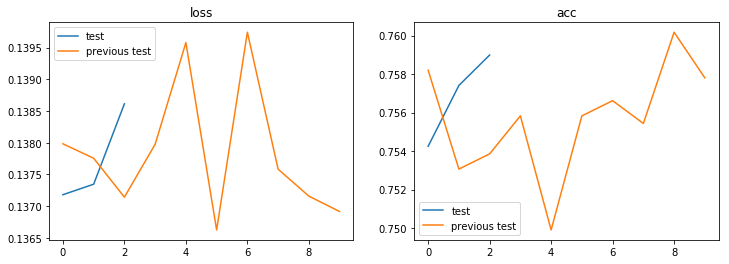

In [370]:
pyplot.figure(figsize=(12,4))

pyplot.subplot(1, 2, 1)
pyplot.title('loss')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.plot(previous_history.history['val_loss'], label='previous test')
pyplot.legend()

pyplot.subplot(1, 2, 2)
pyplot.title('acc')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.plot(previous_history.history['val_acc'], label='previous test')
pyplot.legend()

pyplot.show()

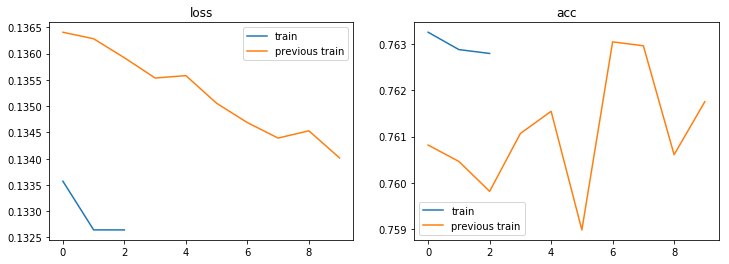

In [371]:
pyplot.figure(figsize=(12,4))

pyplot.subplot(1, 2, 1)
pyplot.title('loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(previous_history.history['loss'], label='previous train')
pyplot.legend()

pyplot.subplot(1, 2, 2)
pyplot.title('acc')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(previous_history.history['acc'], label='previous train')
pyplot.legend()

pyplot.show()

In [372]:
previous_model = model
previous_history = history

In [373]:
for index in range(100, 105):
    print(Y_test.values[index])
    print(model.predict(X_test.values[index:index+1,:])[0])
    print("---------")

[-0.58368435 -0.06756059]
[-0.02537126  0.51426786]
---------
[-0.26232506 -0.1233192 ]
[0.27841747 0.49486244]
---------
[0.41859833 0.60660943]
[0.3180961  0.45976573]
---------
[-0.7007304  -0.64381203]
[0.11359493 0.44077444]
---------
[-0.04080846  0.6689349 ]
[-0.2744051   0.50358117]
---------


In [378]:
import os, time
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl

prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
    {"raw": model.input},
    {"drive": model.output}
)
export_path = os.path.join(
    tf.compat.as_bytes('models/export/{}'.format(model.name)),
    tf.compat.as_bytes('8')
)
builder = saved_model_builder.SavedModelBuilder(export_path)
sess = K.get_session()
builder.add_meta_graph_and_variables(
    sess, [tag_constants.SERVING],
    signature_def_map={'raw': prediction_signature}
)
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/export/first_try/8/saved_model.pb


b'models/export/first_try/8/saved_model.pb'

In [379]:
with open('%s/model.yaml'% export_path.decode("utf-8"), 'a') as the_file:
    the_file.write(model.to_yaml())
with open('%s/model.json'% export_path.decode("utf-8"), 'a') as the_file:
    the_file.write(model.to_json())
model.save('%s/model.h5' % export_path.decode("utf-8"))
model.save_weights('%s/weights.h5' % export_path.decode("utf-8"))